# Overvew
- nb034で作ったeventを使ってDatasetを作成する
- SpectrogramDatasetを改良する
- クラスインバランスを解決する

In [5]:
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

55ad0e3


# CONST

In [6]:
NB = '042'
DEBUG = False
PERIOD = 5
PATH_EVENT = './../data_ignore/event/nb034_event_intensity_500to16000hz/nb034_event_intensity_500to16000hz.pickle'
DIR_EVENT = './../data_ignore/event/'
DATASET = '32khz'
DIR_MODEL = './../data_ignore/model'
PATH_MODEL = './../data_ignore/model/resnest50/resnest50_fast_1s1x64d-d8fbf808.pth'

In [7]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 45
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 20
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 50
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 50
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [145]:
import os
import gc
import typing as tp
import seaborn as sns
import pickle
import logging
import cv2 
import warnings
import math
import time
import yaml
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from contextlib import contextmanager
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
# from torchvision import models
import torch.nn.functional as F
import torch.utils.data as data
import resnest.torch as resnest_torch
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
from torch.nn.modules.utils import _pair

import sys
sys.path.insert(0, './../src/util/')
from const import BIRD_CODE, INV_BIRD_CODE

# My function

In [9]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [10]:
def get_loaders_for_training(dataset_class, args_dataset, args_loader, train_file_list, valid_file_list):
    # # make dataset
    train_dataset = dataset_class(train_file_list, **args_dataset)
    val_dataset = dataset_class(valid_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    valid_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, valid_loader

In [11]:
class SpectrogramDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
#         sr, y = wavfile.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

class SpectrogramEventRmsDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
        self.df_rms = pd.read_csv(PATH_FEAT)
        self.sr_feat = 4

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
        
        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                basename = os.path.basename(wav_path)
                rms = self.df_rms.query('filename == @basename').librosa_rms.values
                x_feat_sec = np.arange(0, len(rms))/self.sr_feat + 1/self.sr_feat
                event_mask = rms > 1.3*np.median(rms)
                
                silent = ~any(event_mask)
                if silent:
                    # event を検出できなかったらランダムにクロップ
                    start = np.random.randint(len_y - effective_length)
                    y = y[start:start + effective_length].astype(np.float32)
                else:
                    choice = random.choice(x_feat_sec[event_mask])
                    ed_sec = x_feat_sec[-1]
                    st_range_sec = 2.5001
                    ed_range_sec = ed_sec - 2.5001
                    range_in = (st_range_sec <= choice) & (choice <= ed_range_sec)
                    if range_in:
                        idxs = np.arange(len_y)
                        x_sec = idxs/sr
                        mask = (choice - 2.5) < x_sec
                        start = idxs[mask][0]
                        y = y[start:start + effective_length].astype(np.float32)
                    else:
                        # ランダムにクロップ
                        start = np.random.randint(len_y - effective_length)
                        y = y[start:start + effective_length].astype(np.float32)
                    
                # ----
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

# Preparation

settings

In [12]:
pd.set_option('display.max_columns', 100)

In [13]:
settings = yaml.safe_load(settings_str)
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

for k, v in settings.items():
    print("[{}]".format(k))
    print(v)
# set_seed(settings["globals"]["seed"])

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 45, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}}
[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}
[loader]
{'train': {'batch_size': 50, 'shuffle': True, 'num_workers': 10, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 50, 'shuffle': False, 'num_workers': 10, 'pin_memory': True, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}
[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}
[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}
[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}


<br>

data path

In [14]:
root = Path.cwd().parent
input_ex_root = root / 'data_ignore/external_dataset' / DATASET
train_resampled_audio_dirs = [input_ex_root / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [15]:
train_resampled_audio_dirs

[PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-01'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-02'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-03'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-04')]

<br>

load data

In [16]:
train = pd.read_csv(train_resampled_audio_dirs[0] / "train_mod.csv")

# Execution

<br>

train_all を作成  
train_all: リサンプル後のファイルパスなどを追加

In [17]:
tmp_list = []
for audio_d in train_resampled_audio_dirs:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for i, wav_f in enumerate(ebird_d.iterdir()):
            bool_n_splits = i==settings['split']['params']['n_splits']
            if bool_n_splits and DEBUG: break  # if DEBUG=True: 1bird/n_splits file
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

if DEBUG: print('----- debug mode -----')
print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


<br>

fold

In [18]:
skf = StratifiedKFold(**settings["split"]["params"])

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id

In [19]:
use_fold = settings["globals"]["use_fold"]
idx_train = train_all['fold']!=use_fold
idx_valid = train_all['fold']==use_fold
train_file_list = train_all[idx_train][['file_path', 'ebird_code']].values.tolist()
valid_file_list = train_all[idx_valid][['file_path', 'ebird_code']].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(valid_file_list)))

[fold 0] train: 17100, val: 4275


In [22]:
train_all.columns

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license', 'resampled_sampling_rate', 'resampled_filename',
       'resampled_channels', 'file_path', 'fold'],
      dtype='object')

# EDA
- すべてのクラスのファイル数を100にする
- 増やす場合は、durationが20以上のものを対象とする

In [56]:
vc = train_all['ebird_code'].value_counts()[::-1]

In [49]:
mask = vc <= 40
vc[mask].index

Index(['redhea', 'buffle', 'coshum', 'hoomer', 'lecthr', 'shshaw', 'rudduc',
       'rufgro', 'rinduc', 'swahaw', 'lewwoo', 'rebmer', 'chiswi', 'norhar2',
       'moublu', 'chukar', 'wessan', 'nrwswa', 'sagspa1', 'gcrfin', 'rthhum',
       'rebsap', 'whfibi', 'amewig', 'doccor', 'baleag', 'wesblu', 'sagthr',
       'whtswi', 'eargre', 'ameavo', 'truswa', 'wesgre', 'norpin', 'eursta',
       'calgul', 'wooduc', 'bongul'],
      dtype='object')

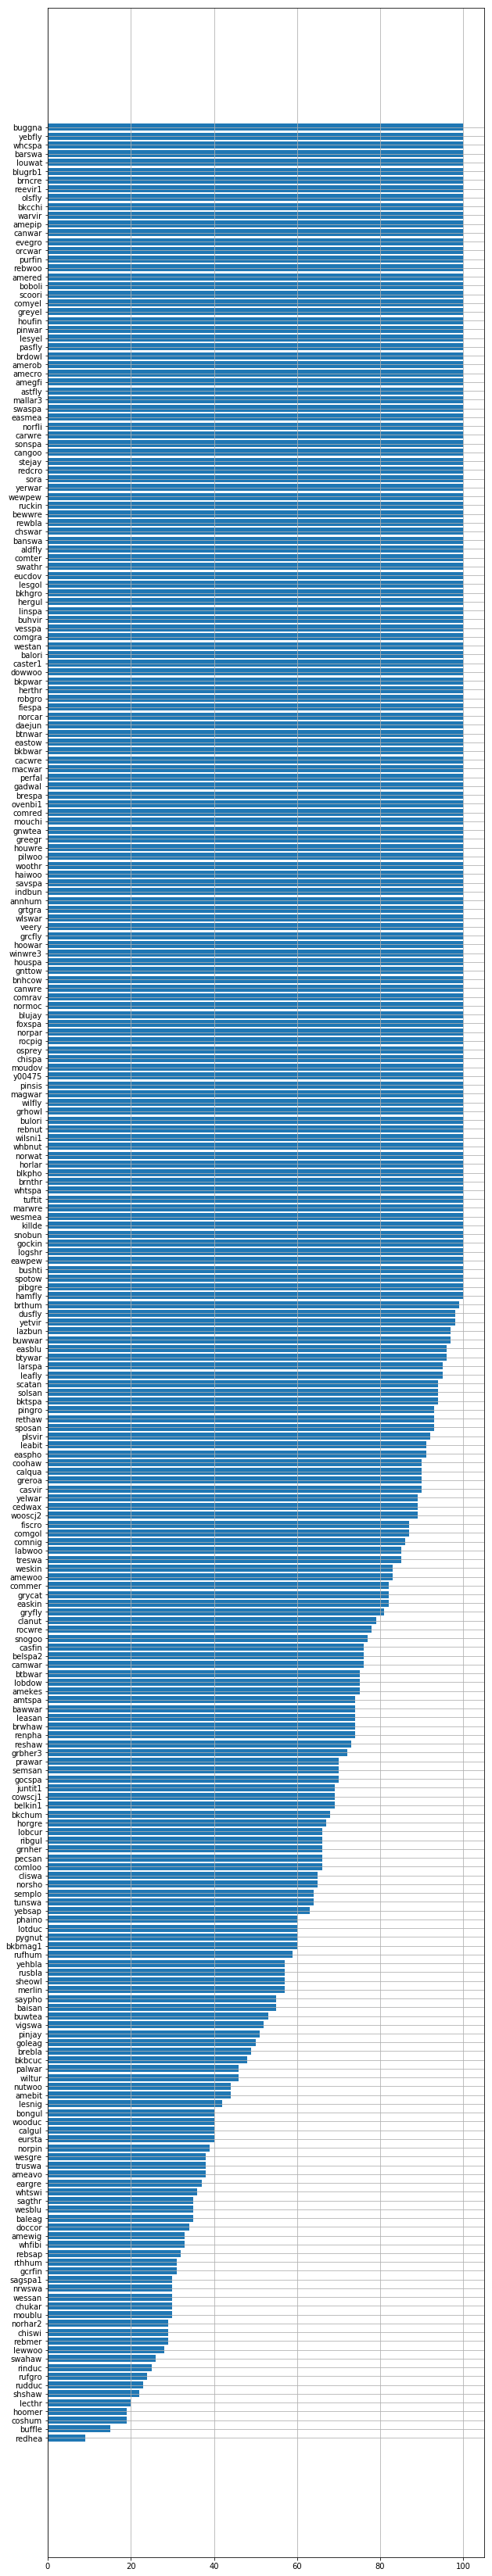

In [57]:
n = 40
# plt.figure(figsize=(10, 20))
# plt.barh(vc.index[:n], vc.values[:n])
plt.figure(figsize=(10, 60))
plt.barh(vc.index, vc.values)
plt.grid()

<br>

duratoin > 20 のwavファイルだけ水増しする

In [140]:
mask = train_all['ebird_code'] == 'redhea'
_df = train_all[mask].sort_values('duration')[::-1]
mask = _df['duration'] > 20
_df = _df[mask]
_df[mask][['file_path', 'duration']].sort_values('duration')[::-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,file_path,duration
15873,/home/user/Git/kaggle-Cornell-Birdcall-Identif...,139
15877,/home/user/Git/kaggle-Cornell-Birdcall-Identif...,125
15870,/home/user/Git/kaggle-Cornell-Birdcall-Identif...,41
15872,/home/user/Git/kaggle-Cornell-Birdcall-Identif...,23


In [141]:
n_add_file = 100 - len(_df)
idx = 0
add_dfs = []
while len(add_dfs) < n_add_file:
    add_dfs.append(_df.iloc[[idx], :])
    if len(_df)-1 > idx:
        idx += 1
    else:
        idx = 0
df_concat = pd.concat(add_dfs)
df_concat.shape

(96, 40)

<br>

すべてのwavファイルに

In [158]:
add_dfs = []
for bird in progress_bar(train_all['ebird_code'].unique()):
    mask = train_all['ebird_code'] == bird
    _df = train_all[mask].sort_values('duration')[::-1]
    mask = _df['duration'] > 20
    df = _df[mask]
    
    n_add_file = 100 - len(_df)
    idx = 0
    dfs = []
    while len(dfs) < n_add_file:
        dfs.append(df.iloc[[idx], :])
        if len(df)-1 > idx:
            idx += 1
        else:
            idx = 0
    
    if len(dfs) == 0:
        pass
    else:
        add_dfs.append(pd.concat(dfs))
df_concat = pd.concat(add_dfs)

In [163]:
df_balanced = pd.concat([train_all, df_concat]).reset_index(drop=True)

---> 完成!!